In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D

In [3]:
df = pd.read_csv("data/input_output_consistency.csv").fillna("")

In [4]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [8]:
df = df.copy()
df["model_temp"] = (
    df["model"] + 
    " (T=" + df["temperature"].astype(str) + 
    ", " + df["fine_tuned"].map({"yes": "ft", "no": "base"}) + ")"
)

In [9]:
df.head(1)

,model,temperature,fine_tuned,training_dataset_size,percentage_exact_restitution,percentage_exact_words_restitution,model_temp
0,GPT-4o,0,yes,small,94.5,99.0,"GPT-4o (T=0, ft)"


In [19]:
set(df.model)

{'GPT-4o', 'GPT-4o mini'}

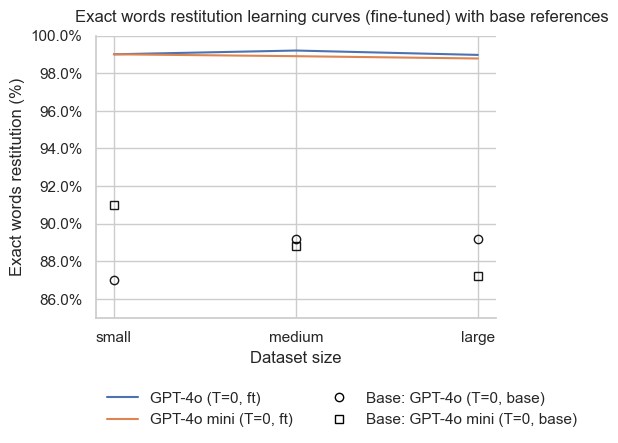

In [28]:
# ==== CONFIG ====
size_order = ["small", "medium", "large"]
metric = "percentage_exact_words_restitution"   # or "percentage_exact_restitution"

# ==== DATAFRAME (pick your variable) ====
# Use df_words if it exists; otherwise fall back to df
dfw = (df_words if "df_words" in globals() else df).copy()

# ==== PREP ====
# Consistent x order
dfw["size"] = pd.Categorical(dfw["training_dataset_size"], categories=size_order, ordered=True)

# Status from 'fine_tuned' if present; else parse model_temp
if "fine_tuned" in dfw.columns:
    status_map = {"yes": "fine-tuned", "no": "base", True: "fine-tuned", False: "base"}
    dfw["status"] = dfw["fine_tuned"].map(lambda x: status_map.get(x, str(x))).str.lower()
else:
    dfw["status"] = np.where(dfw["model_temp"].str.contains("ft", case=False, na=False),
                             "fine-tuned", "base")

# Metric to numeric (% expected in 0–100 already)
dfw[metric] = pd.to_numeric(dfw[metric], errors="coerce")

# ==== PLOT: fine-tuned learning curves ====
sns.set_theme(style="whitegrid")
g = sns.relplot(
    data=dfw[dfw["status"] == "fine-tuned"],
    x="size", y=metric,
    hue="model_temp",
    kind="line",
    markers=True, dashes=True,
    height=4, aspect=1.3
)
g.set_axis_labels("Dataset size", "Exact words restitution (%)")
g.set(xlim=(-0.1, None), ylim=(85, 100))
g.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.1f}%"))

# ==== OVERLAY: base dots (no legend entries here) ====
base_points = (
    dfw[dfw["status"] == "base"]
    .groupby(["model_temp", "size"], as_index=False)
    .agg(y=(metric, "mean"))
)

# marker per base model
base_models = sorted(dfw.loc[dfw["status"] == "base", "model_temp"].dropna().unique())
_markers = ['o','s','^','D','P','X','v','>','<','*']
marker_map = {m: _markers[i % len(_markers)] for i, m in enumerate(base_models)}

ax = g.ax
# map tick label text -> tick position (robust if some sizes missing)
tick_map = {lab.get_text(): pos for lab, pos in zip(ax.get_xticklabels(), ax.get_xticks())}

for _, row in base_points.iterrows():
    x_pos = tick_map.get(str(row["size"]))
    if x_pos is None or pd.isna(row["y"]):
        continue
    ax.plot(
        x_pos, row["y"],
        marker=marker_map.get(row["model_temp"], 'o'),
        mfc="none", mec="black", mew=1.0, linestyle="none", alpha=0.9,
        zorder=5,
        label="_nolegend_"   # <- suppress legend entries from these dots
    )

# ==== LEGEND: rebuild cleanly (fine-tuned lines + one proxy per base model) ====
# Get seaborn's line legend items first
line_handles, line_labels = [], []
if g._legend is not None:
    line_handles = list(g._legend.legend_handles)
    line_labels = [t.get_text() for t in g._legend.texts]

# Remove any existing legends
if g._legend is not None:
    g._legend.remove()
leg = ax.get_legend()
if leg is not None:
    leg.remove()

# Deduplicate fine-tuned items (defensive)
def _dedup(handles, labels):
    seen, H, L = set(), [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l); H.append(h); L.append(l)
    return H, L
line_handles, line_labels = _dedup(line_handles, line_labels)

# Build exactly one proxy per base model
base_proxies = [
    Line2D([0],[0],
           marker=marker_map.get(m, 'o'), mfc='none', mec='black',
           linestyle='none', label=f'Base: {m}')
    for m in base_models
]

# Final combined legend (centered below)
final_handles = line_handles + base_proxies
final_labels  = line_labels  + [h.get_label() for h in base_proxies]

g.fig.legend(
    final_handles, final_labels,
    loc="upper center", bbox_to_anchor=(0.5, 0.1),
    ncol=max(2, len(final_handles) // 2),
    frameon=False
)
g.fig.subplots_adjust(bottom=0.25)

# ==== TITLE ====
g.fig.suptitle(
    "Exact words restitution learning curves (fine-tuned) with base references",
    y=1.02, fontsize=12, ha="center", x=0.5
)

plt.show()

In [29]:
g.savefig("figures/learning_curve_input_output_consistency.png", dpi=300, bbox_inches='tight')